In [1]:
import numpy as np
import tifffile as tiff
import math
from collections import defaultdict
from os import listdir
from os.path import isfile, join
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr,ogr,gdalconst
import shutil

import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import cv2
import shapely
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
import geopandas as gpd
import pandas as pd

import rasterio.features as features
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import shape
from rasterio.transform import from_origin

import rasterio as rio

In [2]:
def array2raster(newRasterfn, dataset, array, dtype):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset : original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte":
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    # setteing srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()



def rasterize_shp(template_raster, shp, dtype, options, output, nodata_val=0):
    print (template_raster)
    print (shp)
    print (dtype)
    print (options)
    model_dataset = gdal.Open(template_raster)
    
    if isinstance(shp, str):
        print('shp from file')
        shape_dataset = ogr.Open(shp)
    elif isinstance(shp, shapely.geometry.multipolygon.MultiPolygon):
        print('shp from polygon')
        shape_dataset = shp
    else:
        shape_dataset = shp
    
    print(type(shape_dataset))
            
    #shape_layer = shape_dataset.GetLayer()
    
    mem_drv = gdal.GetDriverByName('MEM')
    mem_raster = mem_drv.Create(
        '',
        model_dataset.RasterXSize,
        model_dataset.RasterYSize,
        1,
        dtype
    )
    mem_raster.SetProjection(model_dataset.GetProjection())
    mem_raster.SetGeoTransform(model_dataset.GetGeoTransform())
    mem_band = mem_raster.GetRasterBand(1)
    mem_band.Fill(nodata_val)
    mem_band.SetNoDataValue(nodata_val)

    err = gdal.RasterizeLayer(
        mem_raster,
        [1],
        shape_dataset,
        None,
        None,
        [1],
        options
    )
    assert err == gdal.CE_None
    label_array = mem_raster.ReadAsArray()
    label_array[label_array==255] = 1
    array2raster(output, model_dataset, label_array, 'Byte')

In [3]:
def mask_to_polygons(mask, epsilon=10., min_area=10.):
    """Convert a mask ndarray (binarized image) to Multipolygons"""
    # first, find contours with cv2: it's much faster than shapely
    contours, hierarchy = cv2.findContours(mask,
                                  cv2.RETR_CCOMP,
                                  cv2.CHAIN_APPROX_NONE)
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    all_polygons = MultiPolygon(all_polygons)

    return all_polygons

def mask_for_polygons(polygons, im_size):
    """Convert a polygon or multipolygon list back to
       an image mask ndarray"""
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    # function to round and convert to int
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

def create_test_gpd_polygon(list_coords):
    test_polygon = Polygon(list_coords)
    test_mask = mask_for_polygons([test_polygon], im_size=(10,10))
    return mask_to_polygons(test_mask, epsilon=10., min_area=10.)

In [4]:
# local paths
path_data = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset'
area = 'Mosul_2015'
path_file = 's1tiling_S1A_IW_GRDH_1SDV_20150108T030926_20150108T030951_004074_004EC3_B908/38SLF/s1a_38SLF_vv_DES_20150108t030926.tif'
path_file_border_mask = 's1tiling_S1A_IW_GRDH_1SDV_20151222T030932_20151222T030957_009149_00D2A0_F04A/38SLF/s1a_38SLF_vv_DES_20151222t030932_BorderMask.tif'


shape_file = '38SLF_Mosul.shp'
file_label = shape_file[-0:-4] + path_file[-19:-4]

path_raster = join(path_data, area, path_file)
path_border_mask = join(path_data, area, path_file_border_mask)
path_shape_file = join(path_data, area, shape_file)
#path_shape_file = '/Users/jurriaan/ML/UNOSAT_Challenge/UNOSAT-Challenge/38SLF_Mosul.shp'

output = join('/Volumes/other/datasets_and_ML/UNOSAT_Challenge/output_test', 'mosul_test.tif')

In [5]:
# see mask2polygon.ipynb
list_coords = [(0, 0), (10, 20), (40, 50), (90, 30)]
test_polygon = Polygon(list_coords)
test_mask = mask_for_polygons([test_polygon], im_size=(1000,1000))
test_shapes = mask_to_polygons(test_mask, epsilon=10., min_area=10.)

In [6]:
test_mask

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

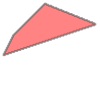

In [7]:
test_shapes

In [8]:
type(test_shapes)

shapely.geometry.multipolygon.MultiPolygon

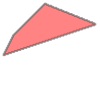

In [9]:
shape(test_shapes)

In [23]:
output = 'rasterize_try_out1.tif'

rasterize_shp(path_raster, test_shapes, gdal.GDT_Byte, ["ATTRIBUTE=DN","ALL_TOUCHED=TRUE"], output)

/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset/Mosul_2015/s1tiling_S1A_IW_GRDH_1SDV_20150108T030926_20150108T030951_004074_004EC3_B908/38SLF/s1a_38SLF_vv_DES_20150108t030926.tif
MULTIPOLYGON (((0 0, 0 1, 1 2, 1 3, 2 4, 2 5, 3 6, 3 7, 4 8, 4 9, 5 10, 5 11, 6 12, 6 13, 7 14, 7 15, 8 16, 8 17, 9 18, 9 19, 10 20, 11 21, 12 22, 13 23, 14 24, 15 25, 16 26, 17 27, 18 28, 19 29, 20 30, 21 31, 22 32, 23 33, 24 34, 25 35, 26 36, 27 37, 28 38, 29 39, 30 40, 31 41, 32 42, 33 43, 34 44, 35 45, 36 46, 37 47, 38 48, 39 49, 40 50, 41 50, 42 49, 43 49, 44 48, 45 48, 46 48, 47 47, 48 47, 49 46, 50 46, 51 46, 52 45, 53 45, 54 44, 55 44, 56 44, 57 43, 58 43, 59 42, 60 42, 61 42, 62 41, 63 41, 64 40, 65 40, 66 40, 67 39, 68 39, 69 38, 70 38, 71 38, 72 37, 73 37, 74 36, 75 36, 76 36, 77 35, 78 35, 79 34, 80 34, 81 34, 82 33, 83 33, 84 32, 85 32, 86 32, 87 31, 88 31, 89 30, 90 30, 89 30, 88 29, 87 29, 86 29, 85 28, 84 28, 83 28, 82 27, 81 27, 80 27, 79 26, 78 26, 77 26, 76 25, 75 25, 74 25, 73

TypeError: in method 'RasterizeLayer', argument 4 of type 'OGRLayerShadow *'

In [78]:
# https://stackoverflow.com/questions/37648439/simplest-way-to-save-array-into-raster-file-in-python

# x_pixels = 100  # number of pixels in x
# y_pixels = 100  # number of pixels in y
# driver = gdal.GetDriverByName('GTiff')
# dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
# dataset.GetRasterBand(1).WriteArray(test_mask)

# # follow code is adding GeoTranform and Projection
# raster_obj = gdal.Open(path_raster)
# geotrans=raster_obj.GetGeoTransform()  #get GeoTranform from existed 'data0'
# proj=raster_obj.GetProjection() #you can get from a exsited tif or import 
# outds.SetGeoTransform(geotrans)
# outds.SetProjection(proj)
# outds.FlushCache()
# outds=None

#not working

NameError: name 'outds' is not defined

In [10]:
dst_filename = 'test_output.tiff'
raster_obj = gdal.Open(path_raster)
array2raster(dst_filename, raster_obj, test_mask, dtype='Float32')
# this works :)!! 
# but now I have a raster, but I actually need a shape file :(

In [12]:
# open raster data
raster_obj= rio.open(path_raster)
# optional - view spatial extent
raster_obj.bounds

BoundingBox(left=300000.0, bottom=3990240.0, right=409790.0, top=4100040.0)

In [13]:
# https://gis.stackexchange.com/questions/166074/create-shapefile-of-raster-outline-using-python
bounds = raster_obj.bounds

dx = 1

# XY = [504675.55,7695881.9]
# nx = 1000 
# west = XY[0]-(nx*dx)/2
# north = XY[1]+(nx*dx)/2


Transform = from_origin(bounds.left, bounds.top, dx,dx)

# Array = np.zeros(shape = (10,10))
# Array[2:4,2:4] = 1
# Array[6:9,6:7] = 2

d = {}
d['val']=list()
geometry = list()

for shp, val in features.shapes(test_mask.astype('int16'), transform=Transform):
    d['val'].append(val)
    geometry.append(shape(shp))
    #print('%s: %s' % (val, shape(shp)))
    
df = pd.DataFrame(data=d)
geo_df = GeoDataFrame(df,crs={'init': 'EPSG:32638'},geometry = geometry)
geo_df['area'] =  geo_df.area 
geo_df.to_file('JustSomeRectanglesInTheNWT.shp', driver = 'ESRI Shapefile')

In [24]:
print(geo_df.iloc[0]['geometry'])

POLYGON ((300000 4100040, 300000 4100038, 300001 4100038, 300001 4100036, 300002 4100036, 300002 4100034, 300003 4100034, 300003 4100032, 300004 4100032, 300004 4100030, 300005 4100030, 300005 4100028, 300006 4100028, 300006 4100026, 300007 4100026, 300007 4100024, 300008 4100024, 300008 4100022, 300009 4100022, 300009 4100020, 300010 4100020, 300010 4100019, 300011 4100019, 300011 4100018, 300012 4100018, 300012 4100017, 300013 4100017, 300013 4100016, 300014 4100016, 300014 4100015, 300015 4100015, 300015 4100014, 300016 4100014, 300016 4100013, 300017 4100013, 300017 4100012, 300018 4100012, 300018 4100011, 300019 4100011, 300019 4100010, 300020 4100010, 300020 4100009, 300021 4100009, 300021 4100008, 300022 4100008, 300022 4100007, 300023 4100007, 300023 4100006, 300024 4100006, 300024 4100005, 300025 4100005, 300025 4100004, 300026 4100004, 300026 4100003, 300027 4100003, 300027 4100002, 300028 4100002, 300028 4100001, 300029 4100001, 300029 4100000, 300030 4100000, 300030 4099999

In [15]:
df = pd.DataFrame(data=d)
geo_df = GeoDataFrame(df,crs={'init': 'EPSG:32638'}, geometry = shape(test_shapes))
geo_df['area'] =  geo_df.area 
geo_df.to_file('JustSomeRectanglesInTheNWT2.shp', driver = 'ESRI Shapefile')

TypeError: unhashable type: 'Polygon'